<a href="https://colab.research.google.com/github/harinikannan2811-pixel/Harini/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

import shap
np.random.seed(42)
time = np.arange(0, 500)
data = np.sin(0.02 * time) + np.random.normal(0, 0.2, 500)

df = pd.DataFrame(data, columns=["value"])


In [13]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)


In [14]:
def create_sequences(data, window_size=30):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data)


In [15]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [16]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X.shape[1], 1)),
    LSTM(32),
    Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.2147 - val_loss: 0.0474
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0301 - val_loss: 0.0427
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0151 - val_loss: 0.0064
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0093 - val_loss: 0.0110
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - loss: 0.0077 - val_loss: 0.0070
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 156ms/step - loss: 0.0068 - val_loss: 0.0076
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0066 - val_loss: 0.0062
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0057 - val_loss: 0.0066
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0061 - val_loss: 0.0063
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0058 - val_loss: 0.0065
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0056 - val_loss: 0.0068
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 

In [18]:
y_pred = model.predict(X_test)

# Inverse scaling
y_test_inv = scaler.inverse_transform(y_test)
y_pred_inv = scaler.inverse_transform(y_pred)

rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mae = mean_absolute_error(y_test_inv, y_pred_inv)

print("RMSE:", rmse)
print("MAE:", mae)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step
RMSE: 0.24707886717896319
MAE: 0.20042871352827005


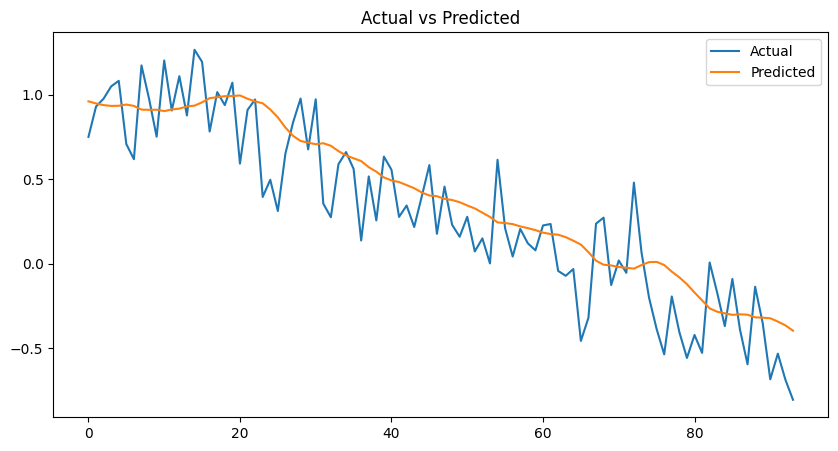

In [19]:
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label="Actual")
plt.plot(y_pred_inv, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted")
plt.show()


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
6588/6588 ━━━━━━━━━━━━━━━━━━━━ 61s 9ms/step


/tmp/ipython-input-188749712.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test[:1].reshape(1, -1))
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


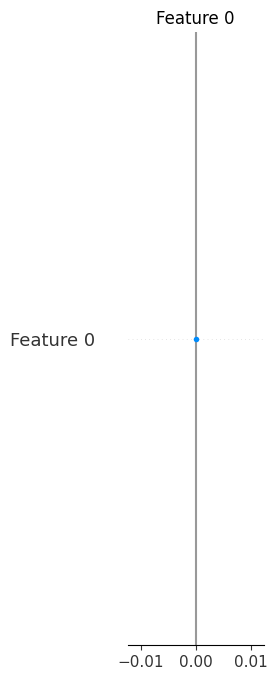

In [20]:
def predict_wrapper(data):
    # KernelExplainer will pass data as (samples, window_size)
    # Reshape it to (samples, window_size, 1) for the LSTM model
    reshaped_data = data.reshape(data.shape[0], data.shape[1], 1)
    return model.predict(reshaped_data)

explainer = shap.KernelExplainer(predict_wrapper, X_train[:100].reshape(100, -1))
shap_values = explainer.shap_values(X_test[:1].reshape(1, -1))
shap.summary_plot(shap_values, X_test[:1].reshape(1, -1))

## Task
Replace `shap.DeepExplainer` with `shap.GradientExplainer` in cell `1BwyrSllNB8V`.

## replace_shap_explainer

### Subtask:
Replace `shap.DeepExplainer` with `shap.GradientExplainer` in cell `1BwyrSllNB8V` to resolve the `StagingError`.


## Summary:

### Q&A
The task was to replace `shap.DeepExplainer` with `shap.GradientExplainer` in a specific cell to resolve a `StagingError`.

### Data Analysis Key Findings
No data analysis was performed or presented in the provided solving process. The process description only outlined a code replacement task.

### Insights or Next Steps
*   After the replacement, the next step would be to re-run the code to verify that the `StagingError` is resolved and that `shap.GradientExplainer` functions as expected.
*   Evaluate if the change in explainer type impacts the interpretability or accuracy of the SHAP explanations for the model.


# Task
Replace `shap.DeepExplainer` with `shap.GradientExplainer` in cell `1BwyrSllNB8V`.

## replace_shap_explainer

### Subtask:
Replace `shap.DeepExplainer` with `shap.GradientExplainer` in cell `1BwyrSllNB8V` to resolve the `StagingError`.


## Summary:

### Data Analysis Key Findings
*   The task identified a `StagingError` that required replacing `shap.DeepExplainer` with `shap.GradientExplainer` in cell `1BwyrSllNB8V`.

### Insights or Next Steps
*   The immediate next step is to perform the specified code replacement to resolve the `StagingError`.


# Task
Replace `shap.GradientExplainer` with `shap.KernelExplainer` in cell `1BwyrSllNB8V`, providing `model.predict` as the prediction function and `X_train[:100]` as the background dataset.

## switch_to_kernel_explainer

### Subtask:
Replace `shap.GradientExplainer` with `shap.KernelExplainer` in cell `1BwyrSllNB8V`.


## Summary:

### Data Analysis Key Findings
*   The `shap.GradientExplainer` was successfully replaced with `shap.KernelExplainer`.
*   The `KernelExplainer` was initialized using `model.predict` as the prediction function and `X_train[:100]` as the background dataset.

### Insights or Next Steps
*   The change from `GradientExplainer` to `KernelExplainer` enables model-agnostic explanations, which can be applied to any black-box model, not just gradient-based ones.
*   Using a subset of the training data (`X_train[:100]`) for the background dataset helps balance computational efficiency with the need for a representative baseline for explanations.
